In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import count, when, col

In [2]:
# Build the SparkSession
spark = SparkSession.builder \
   .master("local") \
   .appName("DDAM Project") \
   .config("spark.executor.memory", "1gb") \
   .getOrCreate()
   
sc = spark.sparkContext

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/11/27 13:26:52 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# import

In [3]:
df_boxscore = spark.read.csv("boxscore.csv", header=True, inferSchema=True)
df_games = spark.read.csv("games.csv", header=True, inferSchema=True)
df_salaries = spark.read.csv("salaries.csv", header=True, inferSchema=True)

In [4]:
print(df_boxscore.count(), df_games.count(), df_salaries.count())

741569 30250 11583


In [5]:
df_boxscore.show(5)

+-------+----------------+------------------+-----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---------+
|game_id|        teamName|        playerName|   MP| FG|FGA| 3P|3PA| FT|FTA|ORB|DRB|TRB|AST|STL|BLK|TOV| PF|PTS|+/-|isStarter|
+-------+----------------+------------------+-----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---------+
|      1|Sacramento Kings|Corliss Williamson|37:20|  7| 11|  0|  0|  0|  0|  1|  3|  4|  4|  1|  1|  4|  5| 14| -2|        1|
|      1|Sacramento Kings|    Mitch Richmond|32:00|  6| 12|  1|  4|  1|  1|  0|  5|  5|  3|  1|  2|  3|  1| 14|-12|        1|
|      1|Sacramento Kings|    Olden Polynice|31:34|  0|  4|  0|  0|  1|  4|  2|  5|  7|  3|  1|  0|  4|  3|  1|-12|        1|
|      1|Sacramento Kings|Mahmoud Abdul-Rauf|29:27|  7| 13|  1|  2|  2|  2|  0|  2|  2|  5|  1|  1|  2|  2| 17| -7|        1|
|      1|Sacramento Kings|       Brian Grant|25:13|  3| 11|  0|  0|  2|  2|  1|  5|  6|  0|  0|  2|  1|  2|  8| -7|   

In [6]:
df_games.show(5)

+---------------+--------------------+----------+--------------------+----------+----------+-----+-------+----------+---------+-------+
|seasonStartYear|            awayTeam|pointsAway|            homeTeam|pointsHome|attendance|notes|startET|  datetime|isRegular|game_id|
+---------------+--------------------+----------+--------------------+----------+----------+-----+-------+----------+---------+-------+
|           1996|    Sacramento Kings|        85|     Houston Rockets|        96|   16285.0| NULL|   NULL|1996-11-01|        1|      1|
|           1996|Los Angeles Clippers|        97|Golden State Warr...|        85|   15593.0| NULL|   NULL|1996-11-01|        1|      2|
|           1996|Portland Trail Bl...|       114| Vancouver Grizzlies|        85|   19193.0| NULL|   NULL|1996-11-01|        1|      3|
|           1996| Seattle SuperSonics|        91|           Utah Jazz|        99|   19911.0| NULL|   NULL|1996-11-01|        1|      4|
|           1996|     New York Knicks|       107

In [7]:
df_salaries.show(5)

+----------------+---------------+-----------+------------------+
|      playerName|seasonStartYear|     salary|inflationAdjSalary|
+----------------+---------------+-----------+------------------+
|  Michael Jordan|           1996|$30,140,000|       $52,258,566|
|    Horace Grant|           1996|$14,857,000|       $25,759,971|
|   Reggie Miller|           1996|$11,250,000|       $19,505,934|
|Shaquille O'Neal|           1996|$10,714,000|       $18,576,585|
|     Gary Payton|           1996|$10,212,000|       $17,706,187|
+----------------+---------------+-----------+------------------+
only showing top 5 rows



# removing columns and dates

In [8]:
#removing notes and startET from df_games
columns_to_drop = ["awayTeam", "pointsAway", "homeTeam", "pointsHome", "attendance", "notes", "startET", "datetime"]

# Drop the specified columns
df_games = df_games.drop(*columns_to_drop)

# Show the first 5 rows of the updated df_games DataFrame
df_games.show(5)

+---------------+---------+-------+
|seasonStartYear|isRegular|game_id|
+---------------+---------+-------+
|           1996|        1|      1|
|           1996|        1|      2|
|           1996|        1|      3|
|           1996|        1|      4|
|           1996|        1|      5|
+---------------+---------+-------+
only showing top 5 rows



In [9]:
#here the plot of the years (the flat line)

In [10]:
df_games = df_games.filter((col("seasonStartYear") >= 2000) & (col("seasonStartYear") <= 2010))
df_games.show(5)

+---------------+---------+-------+
|seasonStartYear|isRegular|game_id|
+---------------+---------+-------+
|           2000|        1|   4577|
|           2000|        1|   4578|
|           2000|        1|   4579|
|           2000|        1|   4580|
|           2000|        1|   4581|
+---------------+---------+-------+
only showing top 5 rows



In [11]:
df_salaries = df_salaries.filter((col("seasonStartYear") >= 2000) & (col("seasonStartYear") <= 2010))
df_salaries.show(5)

+----------------+---------------+-----------+------------------+
|      playerName|seasonStartYear|     salary|inflationAdjSalary|
+----------------+---------------+-----------+------------------+
|   Kevin Garnett|           2000|$19,610,000|       $30,904,632|
|Shaquille O'Neal|           2000|$19,285,715|       $30,393,570|
| Alonzo Mourning|           2000|$16,880,000|       $26,602,253|
|    Juwan Howard|           2000|$16,875,000|       $26,594,373|
| Hakeem Olajuwon|           2000|$16,700,000|       $26,318,580|
+----------------+---------------+-----------+------------------+
only showing top 5 rows



In [12]:
#game_id that are played between 2000 and 2010
selected_game_ids = df_games.select("game_id").distinct()

#filter salaries based on game_id

df_boxscore = df_boxscore.join(selected_game_ids, "game_id")

df_boxscore.show(5)

+-------+-------------------+-------------+-----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---------+
|game_id|           teamName|   playerName|   MP| FG|FGA| 3P|3PA| FT|FTA|ORB|DRB|TRB|AST|STL|BLK|TOV| PF|PTS|+/-|isStarter|
+-------+-------------------+-------------+-----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---------+
|   4577|Seattle SuperSonics|  Gary Payton|48:00| 10| 26|  2|  9|  5|  7|  4| 10| 14| 10|  1|  0|  6|  4| 27| -6|        1|
|   4577|Seattle SuperSonics|    Vin Baker|37:28|  7| 16|  0|  0|  5|  6|  2|  5|  7|  1|  1|  4|  3|  3| 19|  0|        1|
|   4577|Seattle SuperSonics|Patrick Ewing|36:36|  1|  6|  0|  0|  0|  0|  2| 10| 12|  2|  0|  2|  3|  4|  2|-15|        1|
|   4577|Seattle SuperSonics|Rashard Lewis|34:32|  3| 10|  2|  5|  3|  4|  1|  4|  5|  1|  1|  0|  3|  5| 11| -4|        1|
|   4577|Seattle SuperSonics|Desmond Mason|17:01|  3|  9|  0|  3|  1|  2|  3|  2|  5|  2|  0|  1|  1|  5|  7|-15|        1|
+-------

In [13]:
print(df_boxscore.count(), df_games.count(), df_salaries.count())

341806 14264 5098


# missing values

In [14]:
from pyspark.sql.functions import col,isnan, when, count
df_boxscore.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_boxscore.columns]
   ).show()

+-------+--------+----------+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---------+
|game_id|teamName|playerName| MP| FG|FGA| 3P|3PA| FT|FTA|ORB|DRB|TRB|AST|STL|BLK|TOV| PF|PTS|+/-|isStarter|
+-------+--------+----------+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---------+
|      0|       0|         0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0| 19|        0|
+-------+--------+----------+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---------+



In [15]:
#visualize the rows with +/- equal to NULL
rows_with_null = df_boxscore.filter(
    (col("+/-").isNull()))

rows_with_null.show()


+-------+--------------------+--------------------+----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+----+---------+
|game_id|            teamName|          playerName|  MP| FG|FGA| 3P|3PA| FT|FTA|ORB|DRB|TRB|AST|STL|BLK|TOV| PF|PTS| +/-|isStarter|
+-------+--------------------+--------------------+----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+----+---------+
|   5026|       Orlando Magic|            Don Reid|1:00|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|NULL|        0|
|   6348|  Los Angeles Lakers|Stanislav Medvedenko|1:00|  0|  0|  0|  0|  0|  2|  0|  0|  0|  0|  0|  0|  0|  0|  0|NULL|        0|
|   6844|     Detroit Pistons|    Victor Alexander|1:00|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|NULL|        0|
|   7125|Los Angeles Clippers|         Wang Zhizhi|1:06|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|NULL|        0|
|   7153| Cleveland Cavaliers|     Michael Stewart|2:00|  0|  0|  0|  0|  0|

In [16]:
#visualize the rows with +/- equal to 0
filtered_rows = df_boxscore.filter(col("+/-") == 0)

filtered_rows.show(20)


+-------+--------------------+------------------+-----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---------+
|game_id|            teamName|        playerName|   MP| FG|FGA| 3P|3PA| FT|FTA|ORB|DRB|TRB|AST|STL|BLK|TOV| PF|PTS|+/-|isStarter|
+-------+--------------------+------------------+-----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---------+
|   4577| Seattle SuperSonics|         Vin Baker|37:28|  7| 16|  0|  0|  5|  6|  2|  5|  7|  1|  1|  4|  3|  3| 19|  0|        1|
|   4577| Seattle SuperSonics|      Jelani McCoy| 4:37|  0|  0|  0|  0|  0|  0|  0|  1|  1|  1|  0|  0|  0|  0|  0|  0|        0|
|   4577| Vancouver Grizzlies|       Damon Jones| 7:27|  1|  4|  1|  2|  0|  0|  1|  1|  2|  1|  0|  0|  0|  0|  3|  0|        0|
|   4578|       Orlando Magic|      John Amaechi|25:32|  6| 10|  0|  0|  2|  4|  0|  3|  3|  1|  1|  1|  2|  4| 14|  0|        1|
|   4579|     Milwaukee Bucks|      Rafer Alston| 0:20|  0|  0|  0|  0|  0|  0|  1|  0|  1

In [17]:
#change NULL with 0
df_boxscore = df_boxscore.fillna(0, subset=["+/-"])
df_boxscore.show(10)

+-------+-------------------+-----------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+---------+
|game_id|           teamName|       playerName|           MP|           FG|          FGA|           3P|          3PA|           FT|          FTA|          ORB|          DRB|          TRB|          AST|          STL|          BLK|          TOV|           PF|          PTS|          +/-|isStarter|
+-------+-------------------+-----------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+---------+
|   4577|Seattle SuperSonics|      Gary Payton|        48:00|           10|           26|            2|         

In [18]:
from pyspark.sql.functions import col,isnan, when, count
df_salaries.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_salaries.columns]
   ).show()

+----------+---------------+------+------------------+
|playerName|seasonStartYear|salary|inflationAdjSalary|
+----------+---------------+------+------------------+
|         0|              0|     0|                 0|
+----------+---------------+------+------------------+



In [19]:
# Create a list comprehension to count null or NaN values for each column
counts_expr = [count(when(col(c).isNull(), c)).alias(c) if c != 'datetime' else count(when(col(c).isNull(), c)).alias(c+'_null_count') for c in df_games.columns]

# Apply the counts expression to the DataFrame
df_games.select(counts_expr).show()

+---------------+---------+-------+
|seasonStartYear|isRegular|game_id|
+---------------+---------+-------+
|              0|        0|      0|
+---------------+---------+-------+



In [20]:
print(df_boxscore.count(), df_games.count(), df_salaries.count())

341806 14264 5098


In [21]:
#join boxscore and games (for the insertion of the data and the isRegular)
df_boxscore = df_boxscore.join(df_games, "game_id")
df_boxscore.show(20)

+-------+-------------------+-------------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+---------+---------------+---------+
|game_id|           teamName|         playerName|           MP|           FG|          FGA|           3P|          3PA|           FT|          FTA|          ORB|          DRB|          TRB|          AST|          STL|          BLK|          TOV|           PF|          PTS|          +/-|isStarter|seasonStartYear|isRegular|
+-------+-------------------+-------------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+---------+---------------+---------+
|   4577|Seattle SuperSonics

In [22]:
print(df_boxscore.count(), df_games.count(), df_salaries.count())

341806 14264 5098


# managing data types

In [23]:
df_boxscore.printSchema()

root
 |-- game_id: integer (nullable = true)
 |-- teamName: string (nullable = true)
 |-- playerName: string (nullable = true)
 |-- MP: string (nullable = true)
 |-- FG: string (nullable = true)
 |-- FGA: string (nullable = true)
 |-- 3P: string (nullable = true)
 |-- 3PA: string (nullable = true)
 |-- FT: string (nullable = true)
 |-- FTA: string (nullable = true)
 |-- ORB: string (nullable = true)
 |-- DRB: string (nullable = true)
 |-- TRB: string (nullable = true)
 |-- AST: string (nullable = true)
 |-- STL: string (nullable = true)
 |-- BLK: string (nullable = true)
 |-- TOV: string (nullable = true)
 |-- PF: string (nullable = true)
 |-- PTS: string (nullable = true)
 |-- +/-: string (nullable = true)
 |-- isStarter: integer (nullable = true)
 |-- seasonStartYear: integer (nullable = true)
 |-- isRegular: integer (nullable = true)



In [24]:
# Assuming df_boxscore is your DataFrame
columns_to_check = ["FG", "FGA", "3P", "3PA", "FT", "FTA", "ORB", "DRB", "TRB", "AST", "STL", "BLK", "TOV", "PF", "PTS", "+/-"]

# Convert the specified columns to integers, and filter out the rows where the conversion fails
converted_df = df_boxscore.select(
    "*",
    *[col(c).cast("int").isNotNull().alias(c+"_is_int") for c in columns_to_check]
)

# Show the rows where conversion to integer failed
failed_conversion_rows = converted_df.filter(~col("FG_is_int") | ~col("FGA_is_int") |
                                              ~col("3P_is_int") | ~col("3PA_is_int") | ~col("FT_is_int") |
                                              ~col("FTA_is_int") | ~col("ORB_is_int") | ~col("DRB_is_int") |
                                              ~col("TRB_is_int") | ~col("AST_is_int") | ~col("STL_is_int") |
                                              ~col("BLK_is_int") | ~col("TOV_is_int") | ~col("PF_is_int") |
                                              ~col("PTS_is_int") | ~col("+/-_is_int"))

# Count the rows where conversion to integer failed
failed_conversion_count = failed_conversion_rows.count()

# Display the count and the first few rows where the conversion to integer failed
print("Number of rows with non-convertible string values:", failed_conversion_count)



Number of rows with non-convertible string values: 53767


In [25]:

# Assuming df_boxscore is your DataFrame
columns_to_convert = ["FG", "FGA", "3P", "3PA", "FT", "FTA", "ORB", "DRB", "TRB", "AST", "STL", "BLK", "TOV", "PF", "PTS", "+/-"]

# Convert the specified columns to integers and drop rows where conversion is not possible
for column in columns_to_convert:
    df_boxscore = df_boxscore.withColumn(column, col(column).cast("int"))

# Drop rows where any of the specified columns is null after conversion
df_boxscore = df_boxscore.dropna(subset=columns_to_convert)

# Show the first few rows after conversion and removal of rows with non-convertible values
df_boxscore.show(20)


+-------+-------------------+-------------------+-----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---------+---------------+---------+
|game_id|           teamName|         playerName|   MP| FG|FGA| 3P|3PA| FT|FTA|ORB|DRB|TRB|AST|STL|BLK|TOV| PF|PTS|+/-|isStarter|seasonStartYear|isRegular|
+-------+-------------------+-------------------+-----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---------+---------------+---------+
|   4577|Seattle SuperSonics|        Gary Payton|48:00| 10| 26|  2|  9|  5|  7|  4| 10| 14| 10|  1|  0|  6|  4| 27| -6|        1|           2000|        1|
|   4577|Seattle SuperSonics|          Vin Baker|37:28|  7| 16|  0|  0|  5|  6|  2|  5|  7|  1|  1|  4|  3|  3| 19|  0|        1|           2000|        1|
|   4577|Seattle SuperSonics|      Patrick Ewing|36:36|  1|  6|  0|  0|  0|  0|  2| 10| 12|  2|  0|  2|  3|  4|  2|-15|        1|           2000|        1|
|   4577|Seattle SuperSonics|      Rashard Lewis|34:32|  3| 10| 

In [26]:
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType

# Assuming df_boxscore is your DataFrame
def convert_to_seconds(time_str):
    minutes, seconds = map(int, time_str.split(':'))
    return minutes * 60 + seconds

# Create a user-defined function (UDF) for the conversion
convert_to_seconds_udf = udf(convert_to_seconds, IntegerType())

# Apply the UDF to the "MP" column and create a new "MP_seconds" column
df_boxscore = df_boxscore.withColumn("MP_seconds", convert_to_seconds_udf(col("MP")))

# Show the DataFrame with the new "MP_seconds" column
df_boxscore.show(20)


+-------+-------------------+-------------------+-----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---------+---------------+---------+----------+
|game_id|           teamName|         playerName|   MP| FG|FGA| 3P|3PA| FT|FTA|ORB|DRB|TRB|AST|STL|BLK|TOV| PF|PTS|+/-|isStarter|seasonStartYear|isRegular|MP_seconds|
+-------+-------------------+-------------------+-----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---------+---------------+---------+----------+
|   4577|Seattle SuperSonics|        Gary Payton|48:00| 10| 26|  2|  9|  5|  7|  4| 10| 14| 10|  1|  0|  6|  4| 27| -6|        1|           2000|        1|      2880|
|   4577|Seattle SuperSonics|          Vin Baker|37:28|  7| 16|  0|  0|  5|  6|  2|  5|  7|  1|  1|  4|  3|  3| 19|  0|        1|           2000|        1|      2248|
|   4577|Seattle SuperSonics|      Patrick Ewing|36:36|  1|  6|  0|  0|  0|  0|  2| 10| 12|  2|  0|  2|  3|  4|  2|-15|        1|           2000|        1|      2196

In [27]:
#removing notes and startET from df_games
columns_to_drop = ["MP"]

# Drop the specified columns
df_boxscore = df_boxscore.drop(*columns_to_drop)

# Show the first 5 rows of the updated df_games DataFrame
df_boxscore.show(5)

+-------+-------------------+-------------+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---------+---------------+---------+----------+
|game_id|           teamName|   playerName| FG|FGA| 3P|3PA| FT|FTA|ORB|DRB|TRB|AST|STL|BLK|TOV| PF|PTS|+/-|isStarter|seasonStartYear|isRegular|MP_seconds|
+-------+-------------------+-------------+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---------+---------------+---------+----------+
|   4577|Seattle SuperSonics|  Gary Payton| 10| 26|  2|  9|  5|  7|  4| 10| 14| 10|  1|  0|  6|  4| 27| -6|        1|           2000|        1|      2880|
|   4577|Seattle SuperSonics|    Vin Baker|  7| 16|  0|  0|  5|  6|  2|  5|  7|  1|  1|  4|  3|  3| 19|  0|        1|           2000|        1|      2248|
|   4577|Seattle SuperSonics|Patrick Ewing|  1|  6|  0|  0|  0|  0|  2| 10| 12|  2|  0|  2|  3|  4|  2|-15|        1|           2000|        1|      2196|
|   4577|Seattle SuperSonics|Rashard Lewis|  3| 10|  2|  5|  3|  4|  1

In [28]:
from pyspark.sql.functions import col,isnan, when, count
df_boxscore.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_boxscore.columns]
   ).show()

+-------+--------+----------+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---------+---------------+---------+----------+
|game_id|teamName|playerName| FG|FGA| 3P|3PA| FT|FTA|ORB|DRB|TRB|AST|STL|BLK|TOV| PF|PTS|+/-|isStarter|seasonStartYear|isRegular|MP_seconds|
+-------+--------+----------+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---------+---------------+---------+----------+
|      0|       0|         0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|        0|              0|        0|         0|
+-------+--------+----------+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---------+---------------+---------+----------+



In [29]:
df_boxscore.printSchema()

root
 |-- game_id: integer (nullable = true)
 |-- teamName: string (nullable = true)
 |-- playerName: string (nullable = true)
 |-- FG: integer (nullable = true)
 |-- FGA: integer (nullable = true)
 |-- 3P: integer (nullable = true)
 |-- 3PA: integer (nullable = true)
 |-- FT: integer (nullable = true)
 |-- FTA: integer (nullable = true)
 |-- ORB: integer (nullable = true)
 |-- DRB: integer (nullable = true)
 |-- TRB: integer (nullable = true)
 |-- AST: integer (nullable = true)
 |-- STL: integer (nullable = true)
 |-- BLK: integer (nullable = true)
 |-- TOV: integer (nullable = true)
 |-- PF: integer (nullable = true)
 |-- PTS: integer (nullable = true)
 |-- +/-: integer (nullable = true)
 |-- isStarter: integer (nullable = true)
 |-- seasonStartYear: integer (nullable = true)
 |-- isRegular: integer (nullable = true)
 |-- MP_seconds: integer (nullable = true)



In [30]:
print(df_boxscore.count(), df_salaries.count())

288039 5098


## FEATURE ENGINEERING

In [34]:
"""The way this stat helps to see the efficiency 
of a player is that it combines all 
the shots including free-throws, and gives a 
complete picture of how often a player scores. """


# Compute a new column True Shoot Percentage TSP
df_boxscore = df_boxscore.withColumn("TSP", col("PTS")/(2*(col("FGA")+(0.44*col("FTA")))))


"""  effective field goal percentage shows how efficient the scorer is based on
the fact that perimeter shots are worth three points in fact this stats gi"""

# Compute a new column Effective Field Goal percentage EFG
df_boxscore = df_boxscore.withColumn("EFG", (col("FG")+(0.5*col("3P")))/col("FGA"))



"""TO Ratio is the number of turnovers a player or team averages per 100 possessions used.
Highlights good scorers who infrequently pass the ball (i.e. Players who typically catch and shoot."""

df_boxscore = df_boxscore.withColumn("TO_ratio", col("TOV")/(col("FGA")+(col("FTA")*0.44)+col("AST")+col("TOV")))



df_boxscore.show(5)

23/11/27 13:42:48 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+-------------------+-------------+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---------+---------------+---------+----------+-------------------+-------------------+-------------------+
|game_id|           teamName|   playerName| FG|FGA| 3P|3PA| FT|FTA|ORB|DRB|TRB|AST|STL|BLK|TOV| PF|PTS|+/-|isStarter|seasonStartYear|isRegular|MP_seconds|                TSP|                EFG|           TO_ratio|
+-------+-------------------+-------------+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---------+---------------+---------+----------+-------------------+-------------------+-------------------+
|   4577|Seattle SuperSonics|  Gary Payton| 10| 26|  2|  9|  5|  7|  4| 10| 14| 10|  1|  0|  6|  4| 27| -6|        1|           2000|        1|      2880|0.46423658872077034| 0.4230769230769231|0.13309671694764863|
|   4577|Seattle SuperSonics|    Vin Baker|  7| 16|  0|  0|  5|  6|  2|  5|  7|  1|  1|  4|  3|  3| 19|  0|        1|           2000|       

## plottings and summaries


In [31]:
#!pip install pyspark_dist_explore

In [37]:

# Calculate summary statistics using Spark
summary_stats = df_boxscore.summary().toPandas()
print(summary_stats)



  summary             game_id            teamName      playerName  \
0   count              288039              288039          288039   
1    mean  11718.056155590042                None            None   
2  stddev   4117.823367244685                None            None   
3     min                4577       Atlanta Hawks      A.C. Green   
4     25%                8158                None            None   
5     50%               11720                None            None   
6     75%               15275                None            None   
7     max               18840  Washington Wizards  Željko Rebrača   

                   FG                FGA                  3P  \
0              288039             288039              288039   
1  3.5928398584913848  7.969896437635182  0.5772759938758293   
2  3.0969892424349252   5.88539733971473  1.0590763137931538   
3                   0                  0                   0   
4                   1                  3                  

/tmp/ipykernel_207/2076779674.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


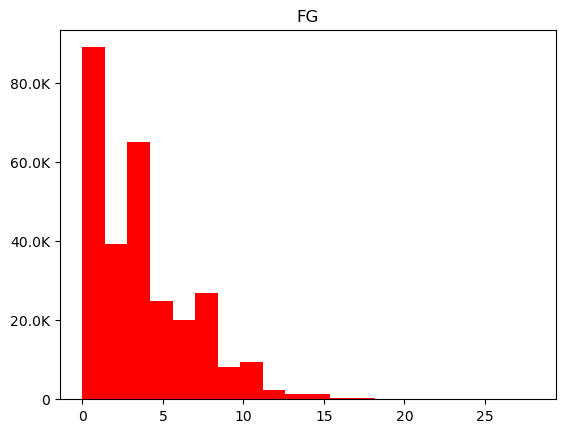

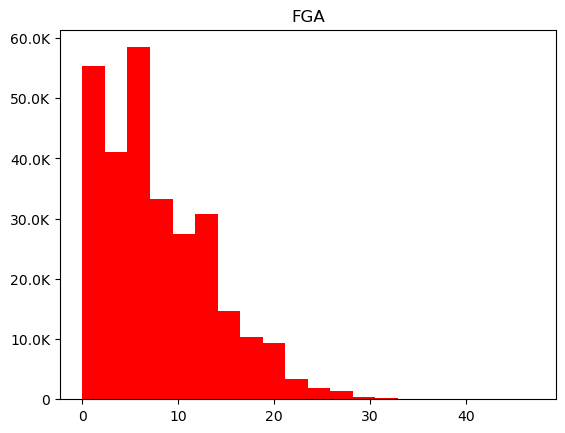

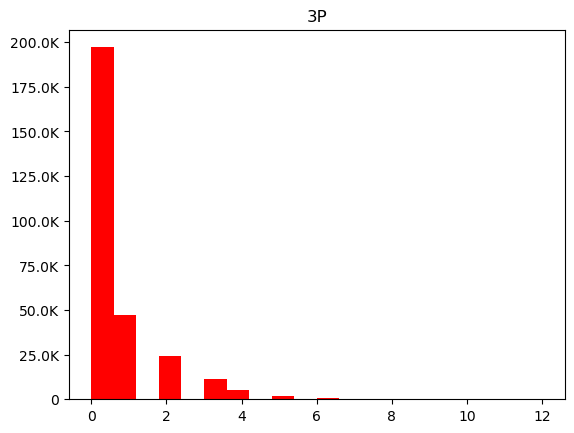

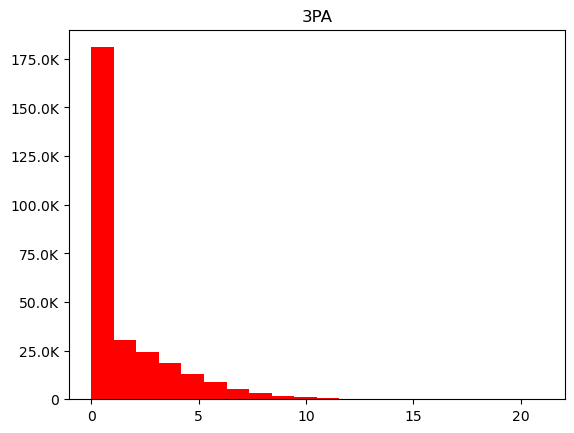

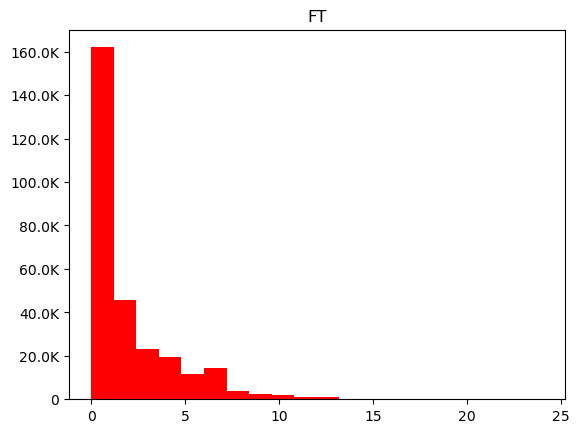

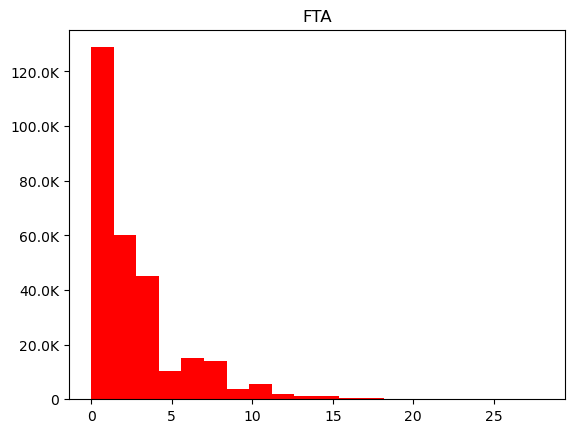

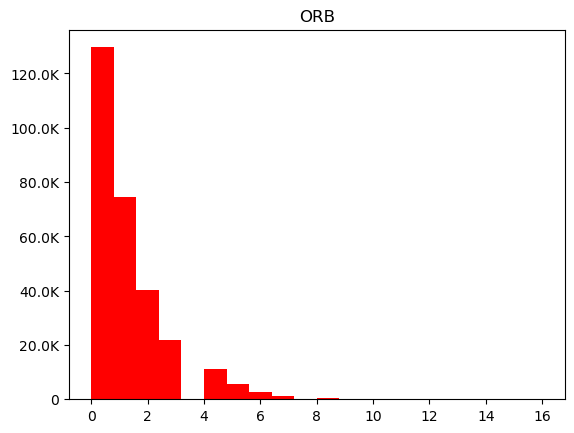

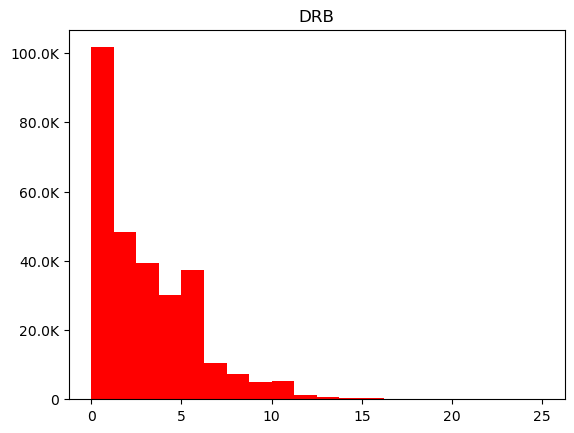

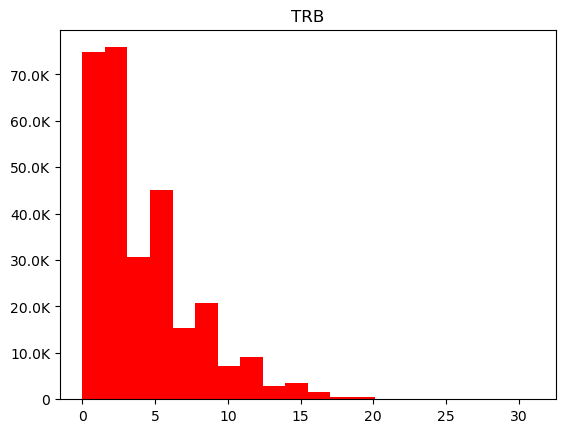

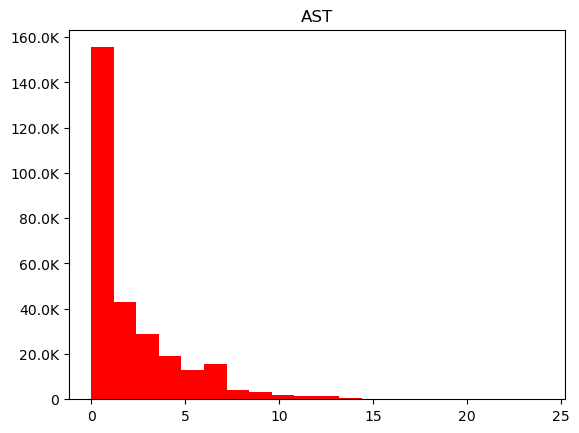

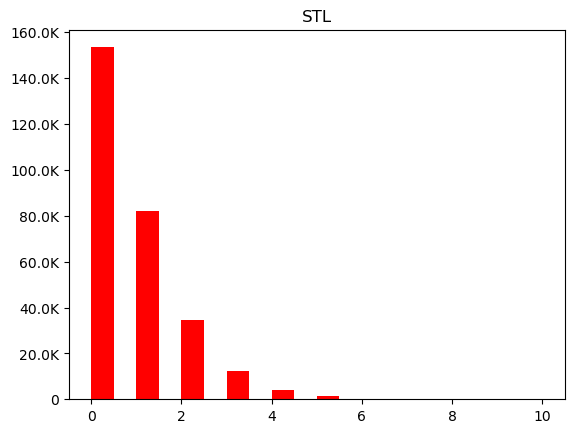

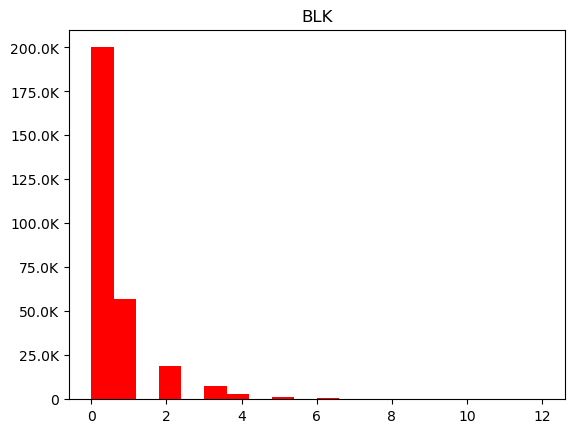

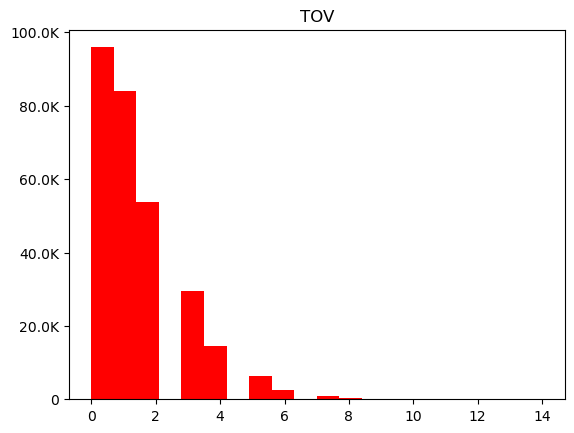

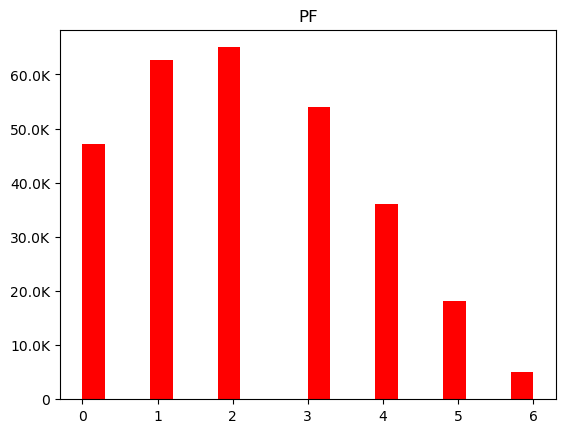

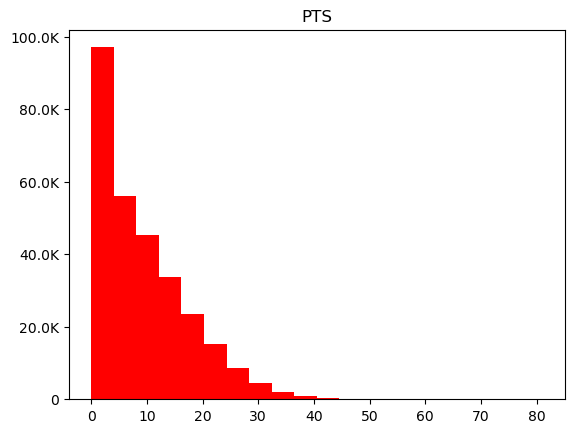

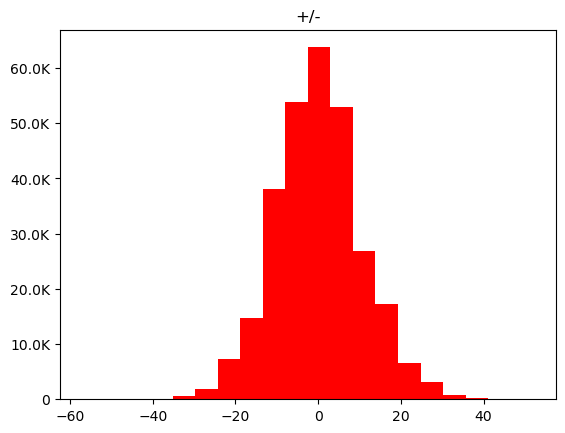

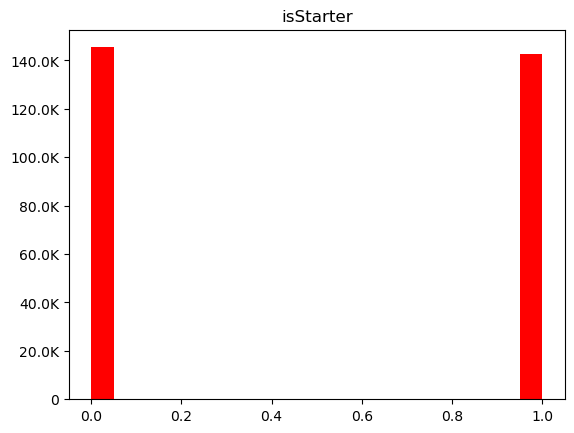

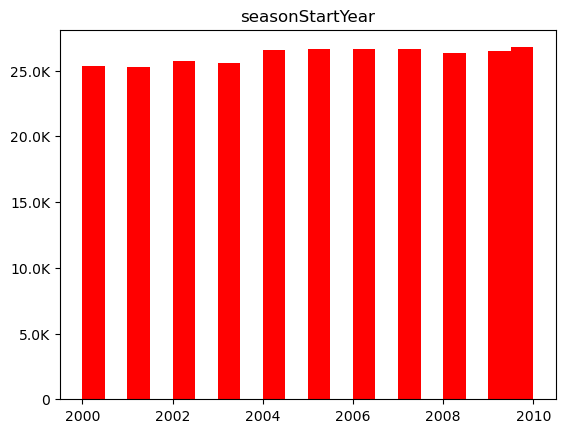

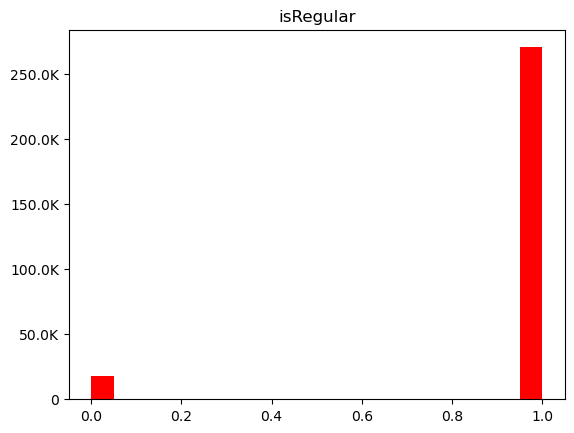

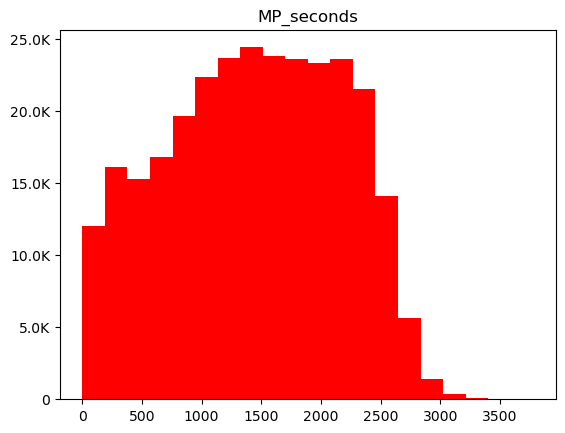

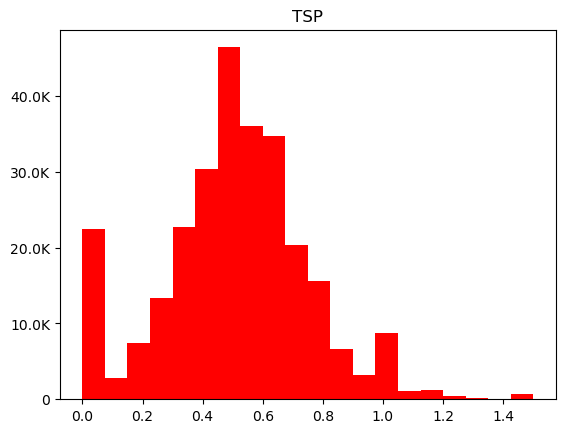

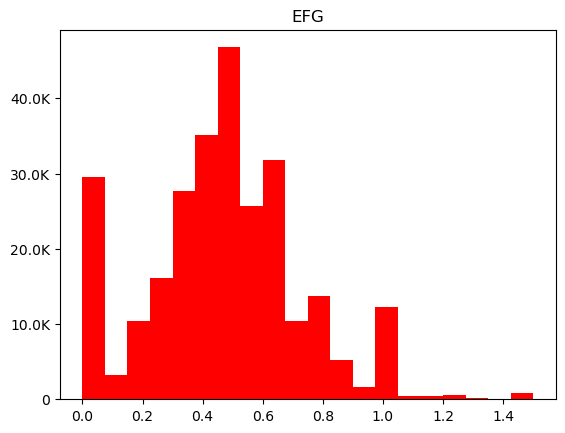

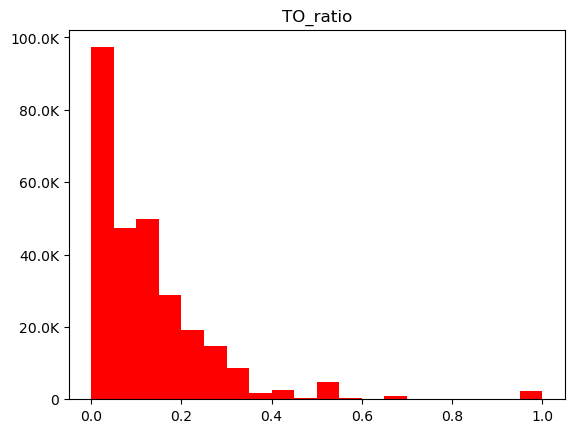

In [36]:
import matplotlib.pyplot as plt
from pyspark_dist_explore import hist


for column in df_boxscore.columns[3:]:
    fig, ax = plt.subplots()
    hist(ax, df_boxscore.select(column), bins = 20, color=['red'])
    ax.set_title(column)

# writing for better sharing

In [38]:
#writing csv for the sharing via github
output_path = "data/df_boxscore_2000-2010"
df_boxscore.write.csv(output_path, header=True, mode="overwrite")

output_path = "data/df_salaries_2000-2010"
df_salaries.write.csv(output_path, header=True, mode="overwrite")